### КЕЙС

Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns  
import plotly.express as px

### Исходные данные

In [2]:
#импорт данных

df_train = pd.read_csv('data/hotels_train.csv') 
df_test = pd.read_csv('data/hotels_test.csv') 

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [5]:
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [6]:
#поиск пропусков в данных

null_data = df_train.isnull().sum()

print(f'\nСтолбцы с явными пропусками данных:\n{null_data[null_data > 0]}')


Столбцы с явными пропусками данных:
lat    2448
lng    2448
dtype: int64


In [7]:
#заполнение пропусокв

df_train_up = df_train.fillna(0)

In [9]:
#для удобства переименую датасет
hotels = df_train

### Оценим влияние расположения отеля на отзыв. Возможно в какой-либо стране отели имеют более высокие характеритики.

In [10]:
addresses = pd.Series(hotels['hotel_address'].unique())

print('\nРассмотрим структуру строк с данными адреса:')
display(addresses)


Рассмотрим структуру строк с данными адреса:


0       Stratton Street Mayfair Westminster Borough Lo...
1       130 134 Southampton Row Camden London WC1B 5AF...
2        151 bis Rue de Rennes 6th arr 75006 Paris France
3       216 Avenue Jean Jaures 19th arr 75019 Paris Fr...
4               Molenwerf 1 1014 AG Amsterdam Netherlands
                              ...                        
1488      Viriotgasse 5 09 Alsergrund 1090 Vienna Austria
1489             8 rue d Anjou 8th arr 75008 Paris France
1490    Prinsengracht 717 Amsterdam City Center 1017 J...
1491    43 Rue De l Abb Gr goire 6th arr 75006 Paris F...
1492    Johann Staud Stra e 32 16 Ottakring 1160 Vienn...
Length: 1493, dtype: object

In [13]:
#выбираем страну из адреса отеля
hotels['hotel_country'] = hotels['hotel_address'].apply(
    lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

### Визуализируем зависимость оценки от страны

Text(0.5, 1.0, 'Зависимость средней оценки\nот страны отеля')

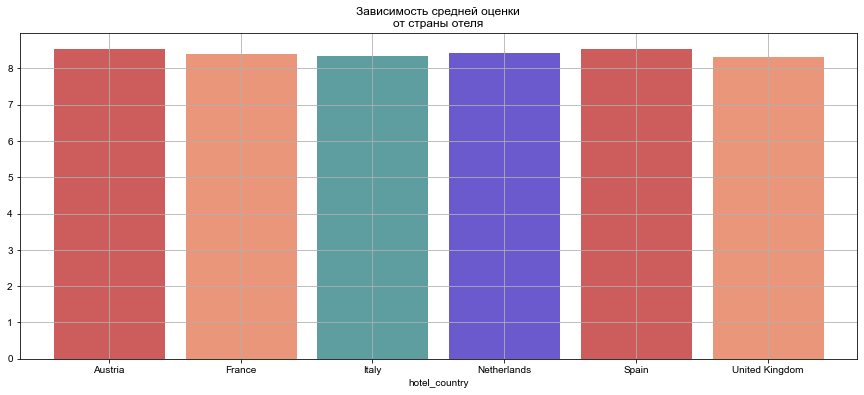

In [14]:
pivot_country_score = hotels.groupby(['hotel_country'])['reviewer_score'].mean()

fig1, ax1 = plt.subplots(figsize=(15, 6))
sns.set_style('whitegrid')
district_type_plot = pivot_country_score.plot(
    ax=ax1, 
    kind='bar', 
    width=0.85, 
    color=['indianred', 'darksalmon', 'cadetblue', 'slateblue'],
    rot=0)

ax1.set_title('Зависимость средней оценки\nот страны отеля')

Средний бал во всех странах примерно одинаковый, можно сделать вывод, что страна, где находится отель не влияет на средний бал.

### Рассмотрим временной период опубликования оценок

In [36]:
#изменим формат даты, оставим месяц опубликования
hotels['month'] = pd.to_datetime(hotels['review_date']).dt.month

In [26]:
# Готовим данные для графика в виде сводной таблицы

data = hotels.groupby('month')['reviewer_score'].agg(count='count').reset_index().sort_values(by='month')
data.head()

,month,count
0,1,144158
1,2,131221
2,3,140657
3,4,147201
4,5,158328


In [37]:
# Фильтруем и готовим данные по влиянию времени на оценку

data1 = hotels[hotels['reviewer_score'] >=8].groupby('month')['reviewer_score'] \
             .agg(count='count').reset_index().sort_values(by='month')

data2 = hotels[hotels['reviewer_score'] <8].groupby('month')['reviewer_score'] \
             .agg(count='count').reset_index().sort_values(by='month')
             
data1.head()

,month,count
0,1,96907
1,2,89982
2,3,94624
3,4,97321
4,5,103226


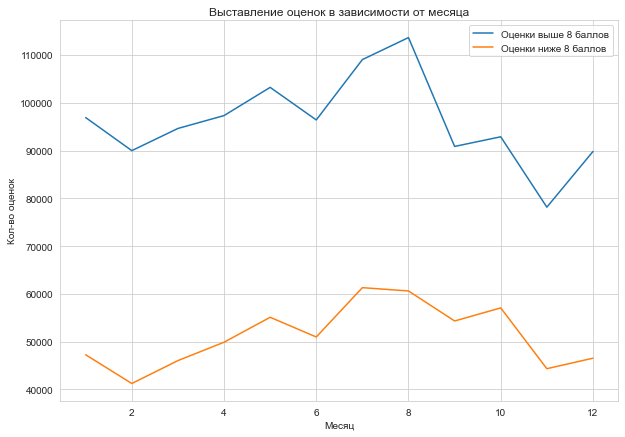

In [38]:
# Строим линейный график с отфильтрованными данными

plt.figure(figsize=(10, 7))

plt.plot(data1['month'], data1['count'])
plt.plot(data2['month'], data2['count'])

plt.title('Выставление оценок в зависимости от месяца')
plt.xlabel('Месяц')
plt.ylabel('Кол-во оценок')
plt.legend(['Оценки выше 8 баллов', 'Оценки ниже 8 баллов'])

plt.show()

#### Здесь очевидный вывод, что с 6 по 8 месяц - сезон отпусков и путешествий, соответственно и увеличение оценок.
Возможно данный параметр имеет смысл учитывать при обучении модели

In [52]:
hotels['word_positiv_count'] = len(hotels['positive_review'])


In [54]:
hotels.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_score,tags,days_since_review,lat,lng,hotel_country,tags_n,date,month,word_positiv_count
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,United Kingdom,Leisure trip,2016-02-19,2,1767522
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,United Kingdom,Couple,2016-02-19,2,1767522


### Рассмотрим Теги для оценки свзя между оценкой и поставленными тегами

In [16]:
# поиск регулярных выражений

import re

def re_func(num_tags):
    found = re.findall("'[^\'](.+?)[^\']'", num_tags)
    return found


hotels['tags_n'] = hotels['tags'].apply(re_func)
hotels = hotels.explode('tags_n')

hotels['tags_n'].unique()
hotels['tags_n'].value_counts()

Leisure trip                            313593
Submitted from a mobile device          230778
Couple                                  189212
Stayed 1 night                          145373
Stayed 2 nights                         100263
                                         ...  
Executive Double Room with Park View         1
Superior Suite with Garden View              1
2 double Connecting Rooms                    1
Art Deco Room Terrace                        1
Suite Marignan Eiffel                        1
Name: tags_n, Length: 2368, dtype: int64

In [59]:
hotels['tags_n'].mode()

0    Leisure trip
dtype: object

### визуализируем связь между теагми и оценками отелей

In [68]:
data = hotels.groupby('tags_n')['reviewer_score'].agg(count='max').reset_index().sort_values(by='tags_n')
data.head()

,tags_n,count
0,1 King Bed Guest Room,9.6
1,2 Adjacent Non Communicating Rooms,10.0
2,2 Adjacent Rooms,10.0
3,2 Connecting Deluxe Rooms with VIP Service for...,8.8
4,2 Connecting Double Rooms,10.0


In [71]:
hotels['tags_n'].describe()

count          1767522
unique            2368
top       Leisure trip
freq            313593
Name: tags_n, dtype: object